# Praos simulation analysis for hypotheses

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Testing hypotheses regarding throughput

In [2]:
readLines("sim-cli.hash")

[1] "sim-cli 1.3.1-66a2eb734"

### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


        Network         Bandwidth               CPU        
 topology-v2:762409   10 Mb/s:762409   4 vCPU/node:762409  
                                                           
                                                           
                                                           
                                                           
                                                           
                                                           
           Diffusion duration            Voting duration    Max EB size    
 L_diff = 1200 slots:762409   L_vote = 1200 slots:762409   0 MB/EB:762409  
                                                                           
                                                                           
                                                                           
                                                                           
                                                                

### Leios throughput is proportional to load until it plateaus when capacity is reached.

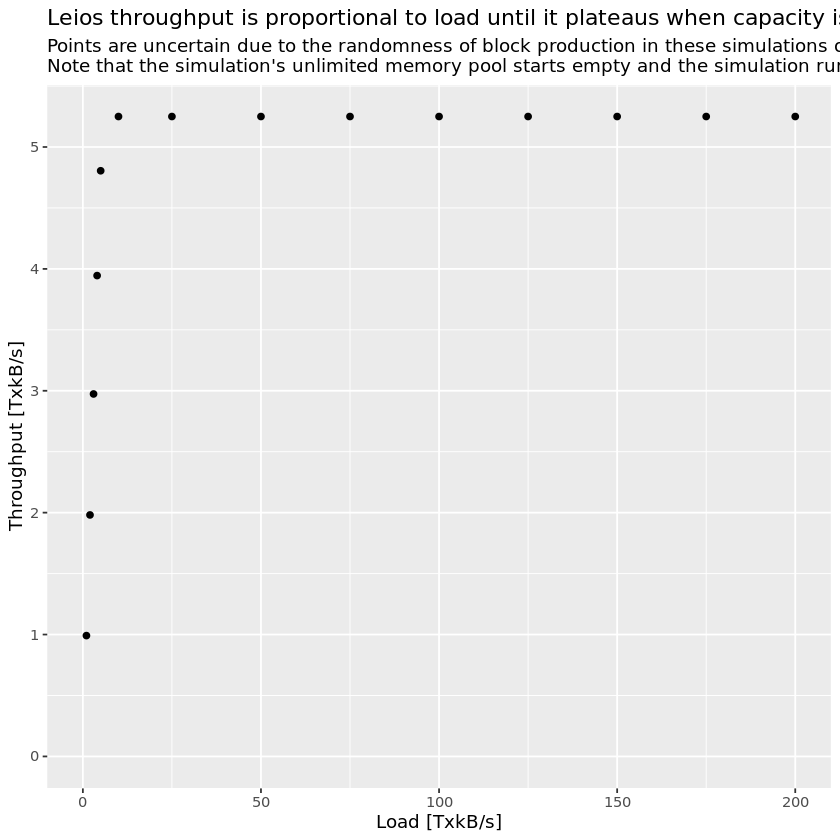

In [4]:
ggplot(
    lifecycle[
        `Message` == "TX" &
        (
            !is.na(`To RB [s]`) & `To RB [s]` >= 0 & `To RB [s]` <= 1200 |
            !is.na(`In RB [s]`) & `In RB [s]` >= 0 & `In RB [s]` <= 1200
        ),
        .(`Throughput [TxkB/s]`=sum(`Size [B]`)/(1200-0)/1000),
        .(
            `Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`Throughput [TxkB/s]`)
) +
    geom_point() +
    xlim(0, NA) +
    ylim(0, NA) +
    ggtitle(
        "Leios throughput is proportional to load until it plateaus when capacity is reached.", 
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that the simulation's unlimited memory pool starts empty and the simulation runs for 1200 slots.",
            sep="\n"
        )
    )

In [5]:
ggsave("plots/load-throughput.png", units="in", dpi=150, width=10, height=6)

In [6]:
ggsave("plots/load-throughput.svg", units="in", dpi=150, width=10, height=6)

### The variability of delivery times plateaus until capacity is reached.

In [7]:
quantiles <- function(created, toRB, inRB) {
    xs <- mapply(
        function(c, t, i) {
            if (is.na(t))
                i - c
            else
                t - c
        }, created, toRB, inRB)
    qs <- c(0.10, 0.50, 0.90)
    quantile(xs, qs) %>% as.numeric
}

In [8]:
lifecycle1 <-
    lifecycle[
        `Message` == "TX" &
        (
            !is.na(`To RB [s]`) & `To RB [s]` >= 0 & `To RB [s]` <= 1200 |
            !is.na(`In RB [s]`) & `In RB [s]` >= 0 & `In RB [s]` <= 1200
        ),
        .(
            `Quantile`=factor(c("10%", "50%", "90%")),
            `Mempool-to-ledger for transactions [s]`=quantiles(`Created [s]`, `To RB [s]`, `In RB [s]`)
        ),
        by=.(
            `Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000
        )
    ]

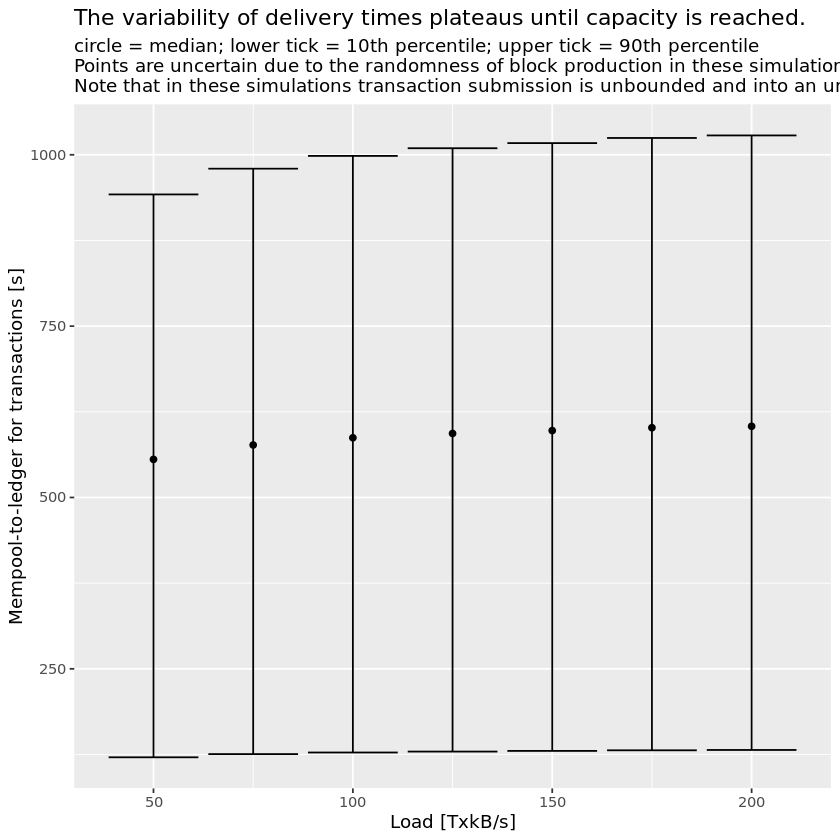

In [9]:
ggplot(
    dcast(
        lifecycle1[`Load [TxkB/s]` >= 50], 
        `Load [TxkB/s]` ~ `Quantile`, 
        value.var="Mempool-to-ledger for transactions [s]"
    ),
    aes(x=`Load [TxkB/s]`)
) +
    geom_errorbar(aes(x=`Load [TxkB/s]`, ymin=`10%`, ymax=`90%`)) +
    geom_point(aes(x=`Load [TxkB/s]`, y=`50%`)) +
    ylab("Mempool-to-ledger for transactions [s]") +
    ggtitle(
        "The variability of delivery times plateaus until capacity is reached.", 
        paste(
            "circle = median; lower tick = 10th percentile; upper tick = 90th percentile",
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [10]:
ggsave("plots/load-txvariance.png", units="in", dpi=150, width=10, height=6)

In [11]:
ggsave("plots/load-txvariance.svg", units="in", dpi=150, width=10, height=6)

### Read resource data

In [12]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources %>% summary

Loaded Rdata file: sampleSize = 1 


        Network        Bandwidth              CPU       
 topology-v2:10500   10 Mb/s:10500   4 vCPU/node:10500  
                                                        
                                                        
                                                        
                                                        
                                                        
                                                        
           Diffusion duration            Voting duration   Max EB size   
 L_diff = 1200 slots:10500    L_vote = 1200 slots:10500   0 MB/EB:10500  
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                          

### The cost of processing per transaction either remains the same or goes down as the load goes up.

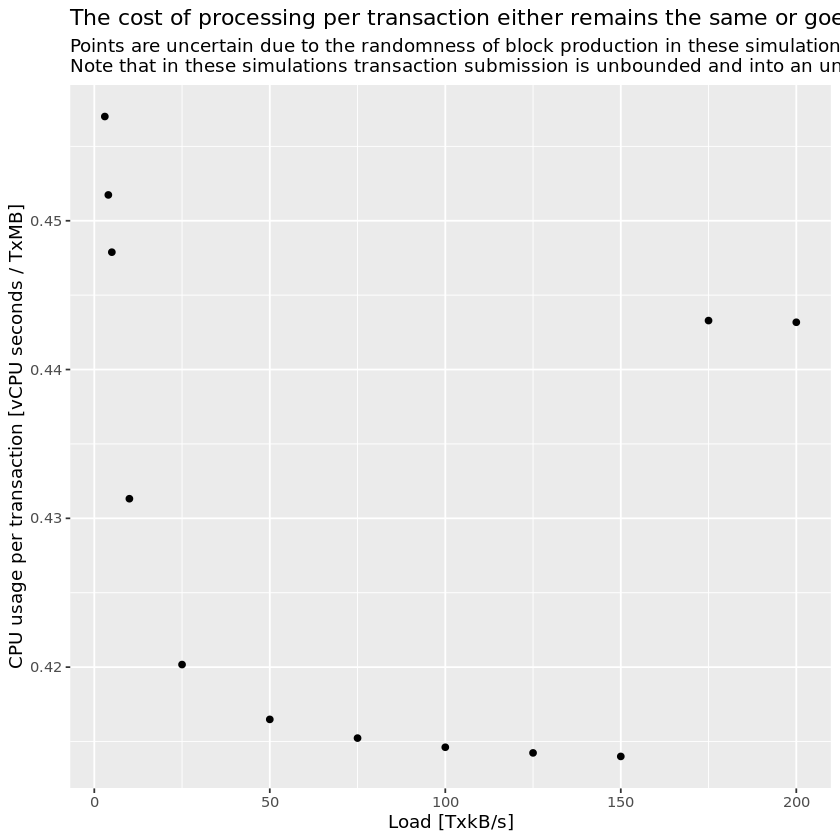

In [13]:
ggplot(
    resources[
        !(`Throughput` %in% c("0.001 TxMB/s", "0.002 TxMB/s")),
        .(
            `CPU usage per transaction [vCPU seconds / TxMB]`=sum(`Total CPU [s]`) / sum(1200 * as.numeric(sub(" .*$","",`Throughput`)))
        ),
        .(
            `Load [TxkB/s]`=1000 * as.numeric(sub(" .*$", "", `Throughput`))
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`CPU usage per transaction [vCPU seconds / TxMB]`)
) +
    geom_point() +
    ggtitle(
        "The cost of processing per transaction either remains the same or goes down as the load goes up.",
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [14]:
ggsave("plots/load-cpu.png", units="in", dpi=150, width=10, height=6)

In [15]:
ggsave("plots/load-cpu.svg", units="in", dpi=150, width=10, height=6)

### The cost of processing per transaction either remains the same or goes down as the load goes up.

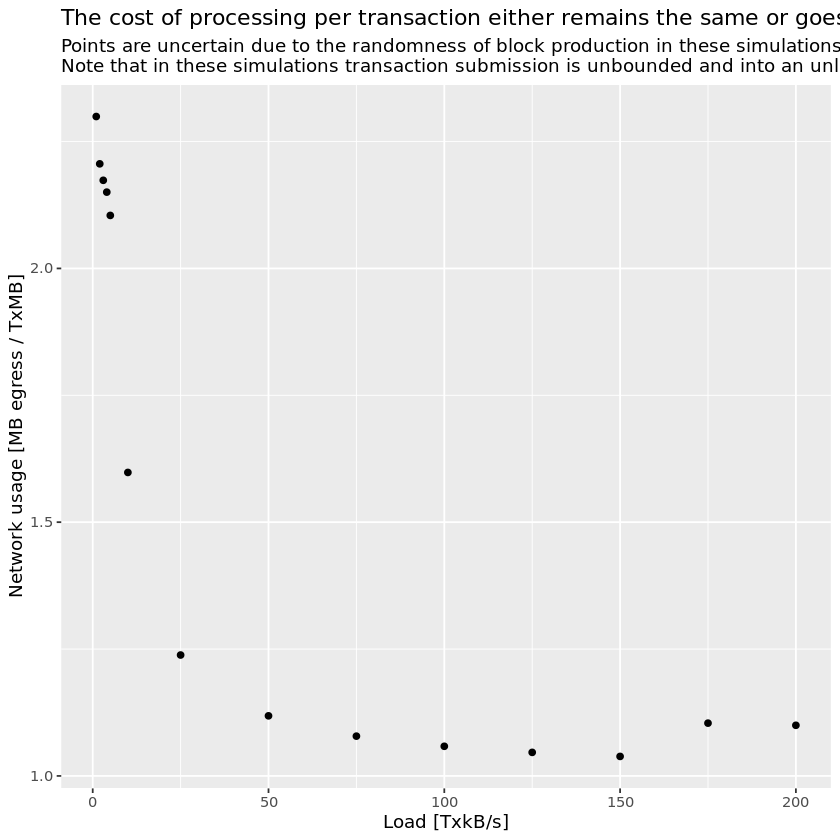

In [16]:
ggplot(
    resources[
        ,
        .(
            `Network usage [MB egress / TxMB]`=sum(`Egress [B]` / 1000000) / sum(1200 * as.numeric(sub(" .*$","",`Throughput`)))
        ),
        .(
            `Load [TxkB/s]`=1000 * as.numeric(sub(" .*$", "", `Throughput`))
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`Network usage [MB egress / TxMB]`)
) +
    geom_point() +
    ggtitle(
        "The cost of processing per transaction either remains the same or goes down as the load goes up.",
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [17]:
ggsave("plots/load-egress.png", units="in", dpi=150, width=10, height=6)

In [18]:
ggsave("plots/load-egress.svg", units="in", dpi=150, width=10, height=6)